# HW2

In [15]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras.datasets import fashion_mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [32]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print (x_train.shape)

(60000, 28, 28, 1)


In [33]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

NameError: name 'Conv2D' is not defined

In [17]:
autoenc = Sequential()
autoenc.add(Dense(32, activation="relu", input_shape=(784,)))
autoenc.add(Dense(784, activation="sigmoid"))

In [18]:
autoenc.compile(optimizer='adadelta', loss='mean_squared_error')

In [19]:
autoenc.fit(x_train, x_train,
                epochs=1,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 1s 17us/step - loss: 0.1213 - val_loss: 0.0931


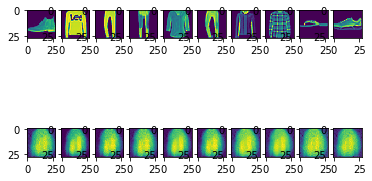

In [29]:
n=10
for k in range(n):
    ax = plt.subplot(2, n, k+1)
    plt.imshow(x_test[k:k+1,:].reshape((28,28)))
    ax = plt.subplot(2, n, k+1 + n)
    reconstruction = autoenc.predict(x_test[k:k+1,:])
    reconstruction.resize((28,28))
    plt.imshow(reconstruction)